In [1]:
# list all files in a directory

import os

pos = []
for file in os.listdir('./aclImdb/train/pos'):
  fd = open(f'./aclImdb/train/pos/{file}')
  x = fd.read()
  pos.append(x)

neg = []
for file in os.listdir('./aclImdb/train/neg'):
  fd = open(f'./aclImdb/train/neg/{file}')
  x = fd.read()
  neg.append(x)

unsup = []
for file in os.listdir('./aclImdb/train/unsup'):
  fd = open(f'./aclImdb/train/unsup/{file}')
  x = fd.read()
  unsup.append(x)

print(len(pos), len(neg), len(unsup))


12500 12500 50000


In [2]:
import pandas as pd

df_pos = pd.DataFrame(pos, columns=['text'])
df_neg = pd.DataFrame(neg, columns=['text'])
df_unsup = pd.DataFrame(unsup, columns=['text'])

df_pos['label'] = 0
df_neg['label'] = 1
df_unsup['label'] = 2

df_pos['set'] = 'train'
df_neg['set'] = 'train'
df_unsup['set'] = 'train'

df = pd.concat([df_pos[0:200], df_neg[0:200], df_unsup[0:200]])
df.head()

,text,label,set
0,For a movie that gets no respect there sure ar...,0,train
1,Bizarre horror movie filled with famous faces ...,0,train
2,"A solid, if unremarkable film. Matthau, as Ein...",0,train
3,It's a strange feeling to sit alone in a theat...,0,train
4,"You probably all already know this by now, but...",0,train


In [3]:
df.iloc(0)

In [4]:
import os
import openai
from dotenv import load_dotenv
load_dotenv()

openai.organization = "org-ITye4e6Cusa0BUGY6ucHrfq3"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.Model.list()

<OpenAIObject list at 0x7fbe3c615400> JSON: {
  "data": [
    {
      "created": 1649358449,
      "id": "babbage",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sampling": true,
          "allow_search_indices": false,
          "allow_view": true,
          "created": 1669085501,
          "group": null,
          "id": "modelperm-49FUp5v084tBB49tC4z8LPH5",
          "is_blocking": false,
          "object": "model_permission",
          "organization": "*"
        }
      ],
      "root": "babbage"
    },
    {
      "created": 1649359874,
      "id": "davinci",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sa

In [5]:
print(len(df))

600


In [11]:
# https://github.com/openai/openai-cookbook/blob/main/examples/Embedding_long_inputs.ipynb

from tenacity import retry, wait_random_exponential, stop_after_attempt, retry_if_not_exception_type
import time
import numpy as np

EMBEDDING_MODEL = 'text-embedding-ada-002'

@retry(
  wait=wait_random_exponential(min=2, max=10), 
  stop=stop_after_attempt(6), 
  retry=retry_if_not_exception_type(openai.InvalidRequestError))
def get_embedding(text_or_tokens, model=EMBEDDING_MODEL):
  print('calling open ai', time.time())
  res = openai.Embedding.create(input=text_or_tokens, model=model)
  time.sleep(1)
  embedding = res['data'][0]['embedding']
  return np.array(embedding, dtype=np.float32)


df['embedding'] = df['text'].apply(get_embedding)

calling open ai 1676610099.995928
calling open ai 1676610101.433654
calling open ai 1676610102.5453298
calling open ai 1676610103.643596
calling open ai 1676610104.74653
calling open ai 1676610106.244148
calling open ai 1676610107.350086
calling open ai 1676610108.469994
calling open ai 1676610109.5713549
calling open ai 1676610110.884769
calling open ai 1676610112.0112371
calling open ai 1676610113.107311
calling open ai 1676610114.5697322
calling open ai 1676610115.68684
calling open ai 1676610116.8103878
calling open ai 1676610117.976287
calling open ai 1676610119.097342
calling open ai 1676610120.201268
calling open ai 1676610121.471623
calling open ai 1676610122.710009
calling open ai 1676610123.8669388
calling open ai 1676610124.9692469
calling open ai 1676610126.089628
calling open ai 1676610127.395233
calling open ai 1676610128.612629
calling open ai 1676610129.711616
calling open ai 1676610132.991426
calling open ai 1676610134.556143
calling open ai 1676610135.663647
calling o

In [12]:
df['embedding']

0      [-0.009286113, -0.01933437, 0.0018802875, -0.0...
1      [0.0005467712, -0.025052378, 0.017882736, -0.0...
2      [-0.011860691, -0.01004855, 0.0037747482, -0.0...
3      [0.02061745, -0.025867263, -0.012810908, -0.02...
4      [7.559758e-05, -0.033851136, -0.006154752, -0....
                             ...                        
195    [0.0037275753, -0.020742375, 0.00786092, -0.01...
196    [-0.007198144, -0.03223252, 0.008471193, -0.03...
197    [-0.011930506, -0.01881676, 0.0051221824, -0.0...
198    [-0.010531467, -0.03954281, 0.01957905, -0.008...
199    [-0.029446768, -0.010972158, -0.003659732, -0....
Name: embedding, Length: 600, dtype: object

In [13]:
df['embedding'].describe()

count                                                   600
unique                                                  600
top       [-0.009286113, -0.01933437, 0.0018802875, -0.0...
freq                                                      1
Name: embedding, dtype: object

<Axes: ylabel='label'>

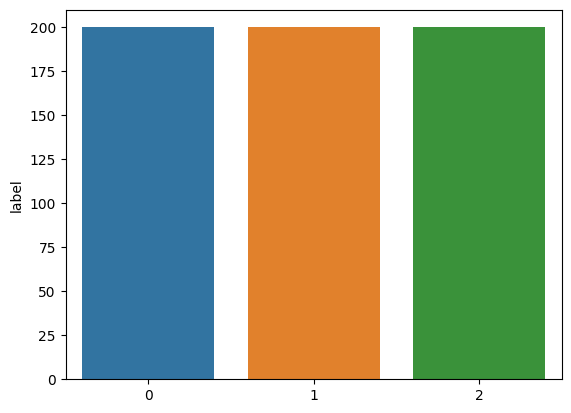

In [14]:
# seaborn bar chart of labels 
import seaborn as sns

sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts())

In [15]:
df.head()

,text,label,set,embedding
0,For a movie that gets no respect there sure ar...,0,train,"[-0.009286113, -0.01933437, 0.0018802875, -0.0..."
1,Bizarre horror movie filled with famous faces ...,0,train,"[0.0005467712, -0.025052378, 0.017882736, -0.0..."
2,"A solid, if unremarkable film. Matthau, as Ein...",0,train,"[-0.011860691, -0.01004855, 0.0037747482, -0.0..."
3,It's a strange feeling to sit alone in a theat...,0,train,"[0.02061745, -0.025867263, -0.012810908, -0.02..."
4,"You probably all already know this by now, but...",0,train,"[7.559758e-05, -0.033851136, -0.006154752, -0...."


(600, 1536)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.131970
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.579659
[t-SNE] KL divergence after 300 iterations: 1.619224


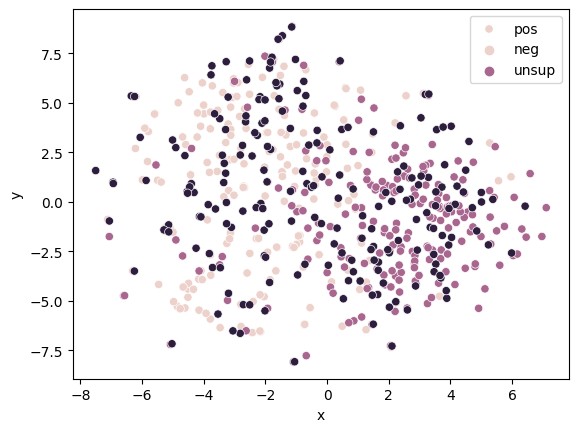

In [18]:
# tsne plot of embeddings for each label
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

samples = df['embedding'].to_list()
X = np.array(samples)

print(X.shape)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['label'] = np.array(df['label'].to_list())

g = sns.scatterplot(x='x', y='y', hue='label', data=df_tsne)
plt.legend(labels=['pos', 'neg', 'unsup'])
plt.show(g)